### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

In [9]:
# Download the data base
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
unzip:  cannot find or open FullIJCNN2013.zip, FullIJCNN2013.zip.zip or FullIJCNN2013.zip.ZIP.


In [10]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [11]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

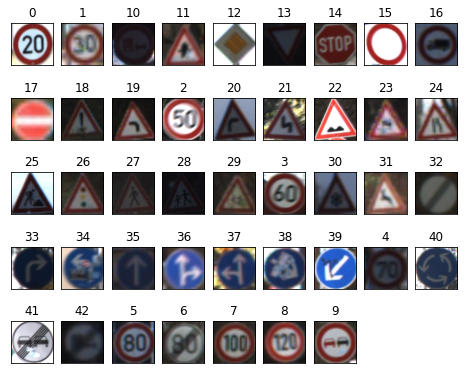

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [14]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

### Assignment 1: Multi-Layer Perceptron

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import experimental

def build_model_v1():
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

def build_model_v2():
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

def build_model_v3():
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [16]:
model = build_model_v1()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [17]:
data = model.fit(tr_signs, tr_labels, batch_size=16, epochs=100, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

NameError: name 'mlp' is not defined